1) 데이터 로드: seaborn 'diamonds'
   - 데이터 형태: (53940, 10)
2) 데이터 분할 완료: 학습 (43152, 9), 테스트 (10788, 9)
3) 모델 학습 시작 (전처리 → 부스팅 3종 → 스태킹)
   - 학습 완료! (186.37s)
4) 테스트 데이터 예측 및 기본 지표
   - MSE : 297,792.42
   - R²  : 0.9813
   - RMSE: 545.70
   - MAE : 283.66


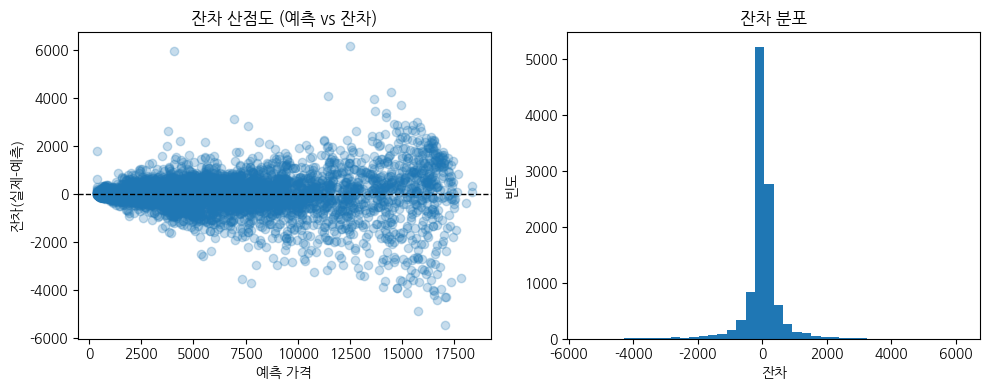

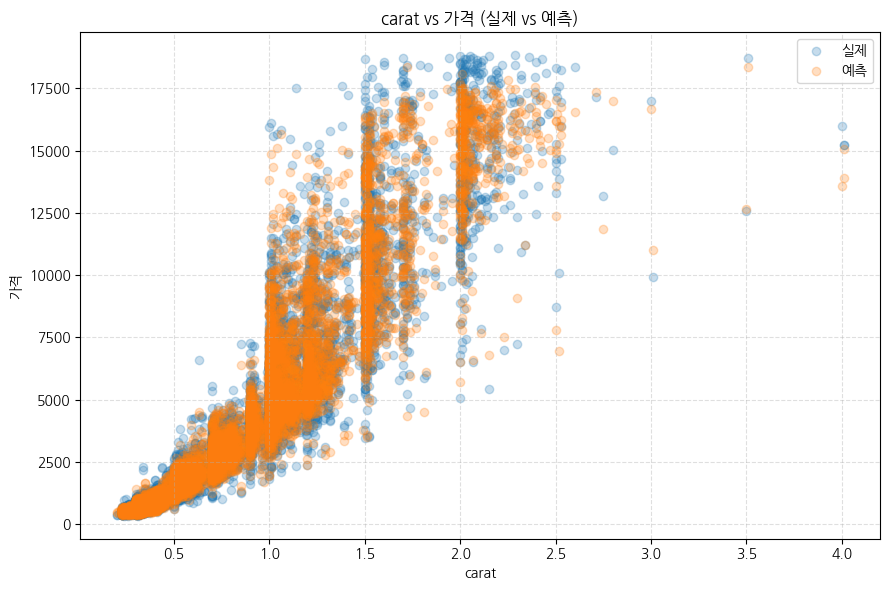

5) Permutation Importance 계산 중... (조금 걸릴 수 있어요)


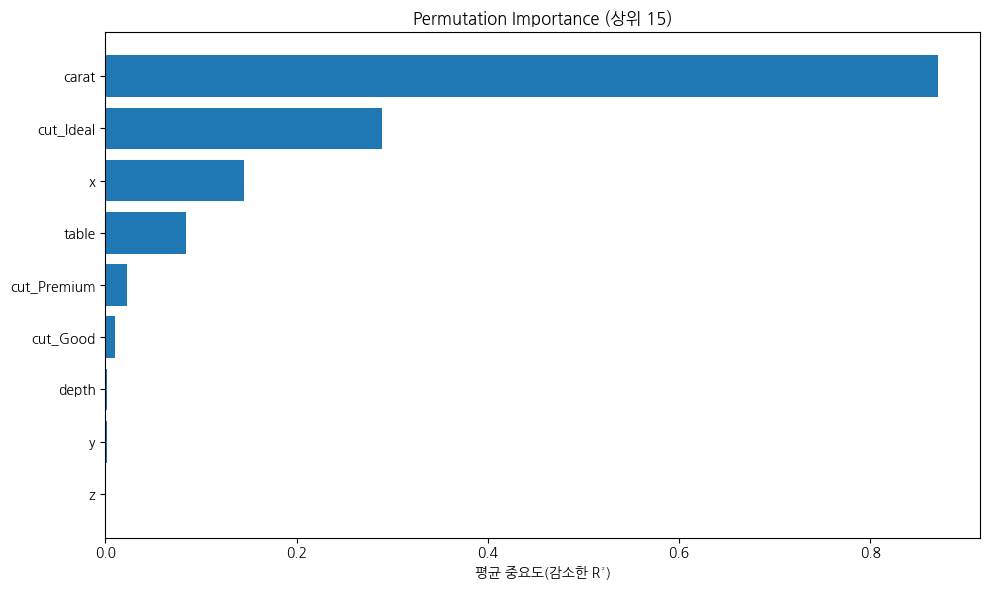

In [1]:
# =========================[1) 시각화 폰트(한글) 세팅]=========================
import matplotlib.pyplot as plt           # 그래프 그리기
import platform                           # 운영체제 감지 (폰트 설정용)

# OS별 폰트 지정 (리눅스: 나눔고딕 / 맥: 애플고딕 / 윈도우: 맑은고딕)
if platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

# =========================[2) 라이브러리 임포트]=========================
import warnings; warnings.filterwarnings('ignore')  # 경고 숨김(선택)
import time                                        # 간단한 학습시간 측정
import numpy as np                                  # 수치 연산
import pandas as pd                                 # 데이터 프레임
import seaborn as sns                               # 예제 데이터 로드

from sklearn.model_selection import train_test_split            # 데이터 분할
from sklearn.preprocessing import OneHotEncoder, StandardScaler # 전처리
from sklearn.compose import ColumnTransformer                   # 열별 전처리
from sklearn.pipeline import Pipeline                           # 파이프라인
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # 평가지표
from sklearn.ensemble import StackingRegressor                  # 스태킹 앙상블
from sklearn.linear_model import LinearRegression               # 메타 모델
from sklearn.inspection import permutation_importance           # 순열 중요도

# 부스팅 3대장 (사전 설치 필요)
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# =========================[3) 데이터 로드]=========================
# seaborn 'diamonds'는 최초 1회 인터넷에서 내려받아 로컬에 캐시됨
print("1) 데이터 로드: seaborn 'diamonds'")
diamonds = sns.load_dataset('diamonds')   # 실패 시 인터넷/버전 확인 필요
print(f"   - 데이터 형태: {diamonds.shape}")  # (행, 열)

# =========================[4) 입력/타깃 분리 + 전처리 정의]=========================
y = diamonds['price']                      # 타깃(가격)
X = diamonds.drop('price', axis=1)         # 입력(나머지 특성)

# 범주형/수치형 컬럼 정의 (원-핫/스케일링에 사용)
categorical_features = ['cut', 'color', 'clarity']
numerical_features   = ['carat', 'depth', 'table', 'x', 'y', 'z']

# 수치형→표준화, 범주형→원-핫 인코딩을 한 번에 적용하는 변환기
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    ],
    remainder='drop'  # 지정한 컬럼만 사용 (필요하면 'passthrough')
)

# =========================[5) 학습/테스트 분할]=========================
# 8:2로 분할, random_state 고정으로 재현 가능
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"2) 데이터 분할 완료: 학습 {X_train.shape}, 테스트 {X_test.shape}")

# =========================[6) 모델 구성 (로그 억제 포함)]=========================
# XGBoost 트리 개수(n_estimators) 기본 100으로 속도/성능 균형
XGB_N_ESTIMATORS = 100

# 스태킹(1단계: 부스팅 3종, 2단계: 선형회귀) + 전처리를 하나로 묶음
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),             # 전처리
    ('regressor', StackingRegressor(           # 스태킹 앙상블
        estimators=[
            ('lgbm', lgb.LGBMRegressor(random_state=42, verbosity=-1)),             # LightGBM(조용)
            ('xgb',  xgb.XGBRegressor(random_state=42, n_estimators=XGB_N_ESTIMATORS, verbosity=0)),  # XGBoost(조용)
            ('cat',  CatBoostRegressor(verbose=0, random_state=42))                 # CatBoost(조용)
        ],
        final_estimator=LinearRegression(),     # 메타 모델
        cv=3                                    # 3겹 CV로 1단계 예측 생성
    ))
])

# =========================[7) 학습 & 기본 평가(MSE, R²)]=========================
print("3) 모델 학습 시작 (전처리 → 부스팅 3종 → 스태킹)")
t0 = time.time()                            # 시작 시간 기록
model_pipeline.fit(X_train, y_train)        # 파이프라인 한 방에 학습
fit_secs = time.time() - t0                 # 학습 소요 시간(초)
print(f"   - 학습 완료! ({fit_secs:.2f}s)")

print("4) 테스트 데이터 예측 및 기본 지표")
y_pred = model_pipeline.predict(X_test)     # 예측
mse = mean_squared_error(y_test, y_pred)    # 평균제곱오차 (낮을수록 좋음)
r2  = r2_score(y_test, y_pred)              # 결정계수 (1에 가까울수록 좋음)
print(f"   - MSE : {mse:,.2f}")
print(f"   - R²  : {r2:.4f}")

# =========================[8) 추가 지표: RMSE, MAE]=========================
# RMSE: MSE의 제곱근(실제 가격 단위로 해석 쉬움), MAE: 평균 절대 오차
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
print(f"   - RMSE: {rmse:,.2f}")
print(f"   - MAE : {mae:,.2f}")

# =========================[9) 잔차 분석(예측 오차 시각화)]=========================
residuals = y_test - y_pred                 # 잔차 = 실제 - 예측

plt.figure(figsize=(10,4))
# (왼쪽) 예측값 대비 잔차 산점도: 0선 주변에 고르게 분포하면 좋음
plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.25)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title("잔차 산점도 (예측 vs 잔차)")
plt.xlabel("예측 가격")
plt.ylabel("잔차(실제-예측)")

# (오른쪽) 잔차 히스토그램: 대칭/정규에 가까우면 좋음
plt.subplot(1,2,2)
plt.hist(residuals, bins=40)
plt.title("잔차 분포")
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

# =========================[10) carat vs 가격 (실제 vs 예측)]=========================
# carat은 가격에 큰 영향을 주는 핵심 수치 특성 → 직관 점검
plt.figure(figsize=(9,6))
plt.scatter(X_test['carat'], y_test, alpha=0.25, label='실제')
plt.scatter(X_test['carat'], y_pred, alpha=0.25, label='예측')
plt.title("carat vs 가격 (실제 vs 예측)")
plt.xlabel("carat")
plt.ylabel("가격")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# =========================[11) Permutation Importance(스태킹 파이프라인 기준)]=========================
# 순열 중요도: 각 특성 값을 섞어 성능(R²)이 얼마나 떨어지는지로 중요도 측정 → 전처리/스태킹 조합에도 안전
print("5) Permutation Importance 계산 중... (조금 걸릴 수 있어요)")
r = permutation_importance(
    model_pipeline, X_test, y_test,
    n_repeats=5, random_state=42, scoring='r2'   # 5회 섞어서 평균 효과 측정
)

# 전처리 후 최종 특성명(수치형 + 원핫 후 범주형)을 재구성
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numerical_features + ohe_feature_names

# 중요도 상위 15개만 시각화 (많으면 해석이 어려워져서)
idx = np.argsort(r.importances_mean)[::-1][:15]  # 내림차순 상위 15
top_names = [all_feature_names[i] for i in idx]
top_scores = r.importances_mean[idx]

plt.figure(figsize=(10,6))
plt.barh(top_names[::-1], top_scores[::-1])   # 위가 크게 보이게 역순
plt.title("Permutation Importance (상위 15)")
plt.xlabel("평균 중요도(감소한 R²)")
plt.tight_layout()
plt.show()
